In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn import neighbors
import joblib

import matplotlib.pyplot as plt

Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423_BSSIDSresilience'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [7]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [8]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [9]:
min(rssidsnums),max(rssidsnums)

(1, 312)

In [10]:
print(len(rssidsnums)*0.5),print(len(rssidsnums)*0.75)

156.0
234.0


(None, None)

In [11]:
# np.random.seed(2022)
# selected_rsidnums=np.sort(np.random.choice(np.arange(min(rssidsnums),max(rssidsnums)), size=234,replace=False))
# selected_rsids=['rsid'+str(x) for x in selected_rsidnums]
# TRAIN_FEATS=selected_rsids[:]
TRAIN_FEATS=[x for x in data.columns if 'rsid' in x]
print(len(TRAIN_FEATS))

312


In [12]:
# selected_columns=selected_rsids[:]+ ['x', 'y', 'path', 'timestamp']
selected_columns=TRAIN_FEATS[:]+ ['x', 'y', 'path', 'timestamp']
print(len(selected_columns))

316


In [13]:
# data.head()

In [14]:
# TRAIN_FEATS=selected_rsids[:]
# # TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
# len(TRAIN_FEATS)

In [15]:
# dataA=data.copy()

In [16]:
# data=dataA.loc[data.setNum==1,:]
# data.shape

In [17]:
unpaths=data.path.unique()

In [18]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


In [19]:
len(TRAIN_FEATS)

312

### CV TRAIN

In [23]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]

all_preds=[]
all_targets=[]

np.random.seed(42)
sh=np.random.permutation(unpaths)

knn_models=[]

k=5
val_size=int(len(sh)/k)
for f in range(k):
    # print('fold:', f)

    if f<(k-1):
        val_paths=sh[val_size*f:val_size*(f+1)]
    else:
        val_paths=sh[val_size*f:]

    train_paths=[x for x in unpaths if x not in val_paths]
    
    val_paths=np.array(val_paths)
    train_paths=np.array(train_paths)
    
    X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

    y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

    X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
    y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


    knn = neighbors.KNeighborsRegressor(45, weights='distance')
    knn.fit(X_train, y_trainXY)
    val_predsXY = knn.predict(X_val)
    knn_models.append(knn)
    # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

    all_preds.append(val_predsXY)
    all_targets.append(y_valXY)
        

all_predsV=np.vstack(all_preds)
all_targetsV=np.vstack(all_targets)    
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
print(np.mean(scores))
print('---------------------')


mean validation error, 5-fold 2.404093368633137
2.404093368633137
---------------------


In [24]:
knn_models

[KNeighborsRegressor(n_neighbors=45, weights='distance'),
 KNeighborsRegressor(n_neighbors=45, weights='distance'),
 KNeighborsRegressor(n_neighbors=45, weights='distance'),
 KNeighborsRegressor(n_neighbors=45, weights='distance'),
 KNeighborsRegressor(n_neighbors=45, weights='distance')]

In [27]:
np.random.seed(42)
np.random.permutation(unpaths)[:5]


array(['record_2021_10_08_12_42_43', 'record_2021_10_13_07_52_19',
       'record_2021_10_08_08_00_47', 'record_2021_10_15_07_37_40',
       'record_2021_10_13_07_37_44'], dtype=object)

In [28]:
np.random.seed(42)
np.random.permutation(unpaths)[:5]


array(['record_2021_10_08_12_42_43', 'record_2021_10_13_07_52_19',
       'record_2021_10_08_08_00_47', 'record_2021_10_15_07_37_40',
       'record_2021_10_13_07_37_44'], dtype=object)

In [32]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]



np.random.seed(42)
sh=np.random.permutation(unpaths)


k=5
val_size=int(len(sh)/k)
for i in range(1,312):
    all_preds=[]
    all_targets=[]
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        # train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        # train_paths=np.array(train_paths)
        
        # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val.iloc[:,-i:]=-999

        knn = knn_models[f]
        val_predsXY = knn.predict(X_val)
        # knn_models.append(knn)
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)


    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)   
    score =  euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1])
    print(i,'mean validation error, 5-fold', score)
    scores.append( score )
    # print(np.mean(scores))
    # print('---------------------')


1 mean validation error, 5-fold 2.403601248143072
2 mean validation error, 5-fold 2.402250982208859
3 mean validation error, 5-fold 2.4035179329581124
4 mean validation error, 5-fold 2.4068188241871584
5 mean validation error, 5-fold 2.4058424058471535
6 mean validation error, 5-fold 2.4099550919664887
7 mean validation error, 5-fold 2.415989680849643
8 mean validation error, 5-fold 2.4370977160543097
9 mean validation error, 5-fold 2.4700939803924173
10 mean validation error, 5-fold 2.519504365551111
11 mean validation error, 5-fold 2.5489220891580233
12 mean validation error, 5-fold 2.5833834792282584
13 mean validation error, 5-fold 2.6187884579611493
14 mean validation error, 5-fold 2.617935458264108
15 mean validation error, 5-fold 2.6204090217432228
16 mean validation error, 5-fold 2.6304756216962004
17 mean validation error, 5-fold 2.6564449709862976
18 mean validation error, 5-fold 2.7029072180598686
19 mean validation error, 5-fold 2.7790682458244484
20 mean validation error, 

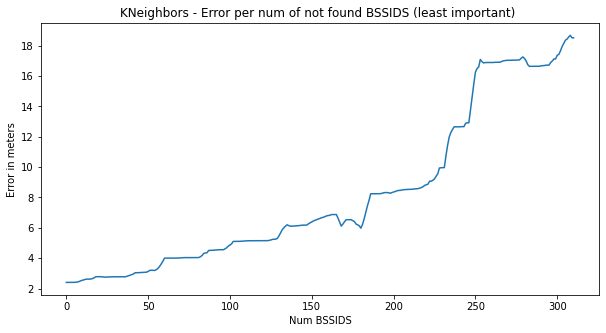

In [33]:
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('KNeighbors - Error per num of not found BSSIDS (least important) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [34]:
len(scores)

311

In [35]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'_LeastImportant.csv',index=False)

In [36]:
version

'forPdata423_BSSIDSresilience'

In [37]:
scores1=scores[:]

In [38]:
X_val.dtypes

rsid1      int64
rsid2      int64
rsid3      int64
rsid4      int64
rsid5      int64
           ...  
rsid308    int64
rsid309    int64
rsid310    int64
rsid311    int64
rsid312    int64
Length: 312, dtype: object

In [39]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]



np.random.seed(42)
sh=np.random.permutation(unpaths)


k=5
val_size=int(len(sh)/k)
for rs in range(1,312):
    all_preds=[]
    all_targets=[]
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        # train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        # train_paths=np.array(train_paths)
        
        # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val.iloc[:,np.random.choice(np.arange(312),size=rs, replace=False)]=-999

        knn = knn_models[f]
        val_predsXY = knn.predict(X_val)
        # knn_models.append(knn)
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    # print(np.mean(scores))
    # print('---------------------')


1 mean validation error, 5-fold 2.4038020204193487
2 mean validation error, 5-fold 2.4093516465923868
3 mean validation error, 5-fold 2.4079347536546107
4 mean validation error, 5-fold 2.4208256051485413
5 mean validation error, 5-fold 2.412881866542538
6 mean validation error, 5-fold 2.412991851028242
7 mean validation error, 5-fold 2.4273434005515644
8 mean validation error, 5-fold 2.428843994073501
9 mean validation error, 5-fold 2.4168104913120856
10 mean validation error, 5-fold 2.429261433421226
11 mean validation error, 5-fold 2.4364892480906084
12 mean validation error, 5-fold 2.4338580212019765
13 mean validation error, 5-fold 2.445274930024293
14 mean validation error, 5-fold 2.4448798809990975
15 mean validation error, 5-fold 2.4280772656057583
16 mean validation error, 5-fold 2.4453378707158984
17 mean validation error, 5-fold 2.4546727786255262
18 mean validation error, 5-fold 2.4607372088318
19 mean validation error, 5-fold 2.442723244237914
20 mean validation error, 5-fo

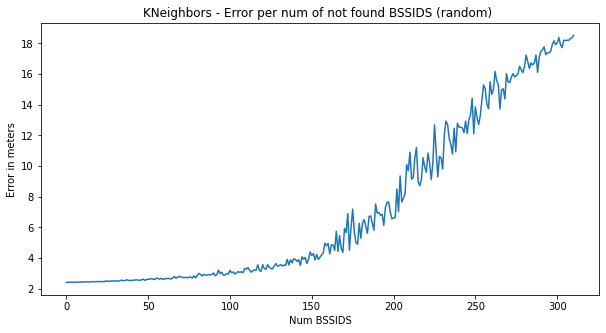

In [40]:
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('KNeighbors - Error per num of not found BSSIDS (random) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [41]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'_random.csv',index=False)

In [ ]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]

# all_preds=[]
# all_targets=[]

np.random.seed(42)
sh=np.random.permutation(unpaths)

REPEATS=3
   
k=5
val_size=int(len(sh)/k)
for i in range(1,312):
    all_predsRs=[]
    for r in range(REPEATS):
        all_preds=[]
        all_targets=[]

        for f in range(k):
            # print('fold:', f)

            if f<(k-1):
                val_paths=sh[val_size*f:val_size*(f+1)]
            else:
                val_paths=sh[val_size*f:]

            train_paths=[x for x in unpaths if x not in val_paths]
            
            val_paths=np.array(val_paths)
            train_paths=np.array(train_paths)
            
            # X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

            # y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

            X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
            y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

            X_val.iloc[:,np.random.choice(np.arange(312),size=i, replace=False)]=-999
            

            knn = knn_models[f]
            val_predsXY = knn.predict(X_val)
            # knn_models.append(knn)
            # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

            all_preds.append(val_predsXY)
            all_targets.append(y_valXY)

        all_predsRs.append(np.vstack(all_preds))
    all_preds= np.mean(np.stack(all_predsRs),0)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(i,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    # print(np.mean(scores))
    # print('---------------------')


In [ ]:
np.stack(all_predsRs).shape,np.vstack(all_targets).shape

((3, 14373, 2), (14373, 2))

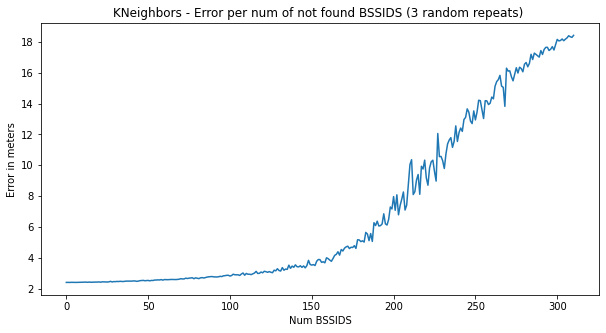

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(scores)
plt.title('KNeighbors - Error per num of not found BSSIDS (3 random repeats) ')
plt.xlabel('Num BSSIDS')
plt.ylabel('Error in meters')
plt.show()


In [ ]:
pd.DataFrame({'num_bssids':np.arange(1,312),
              'scores':np.array(scores)}).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'_random3R.csv',index=False)

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV_'+version+'.csv.gz', index=False, compression='gzip')

## EVALUATION - PLOTS

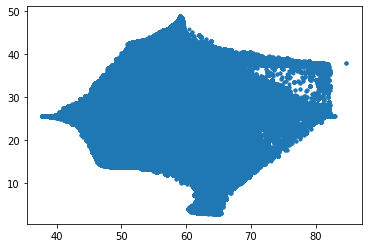

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

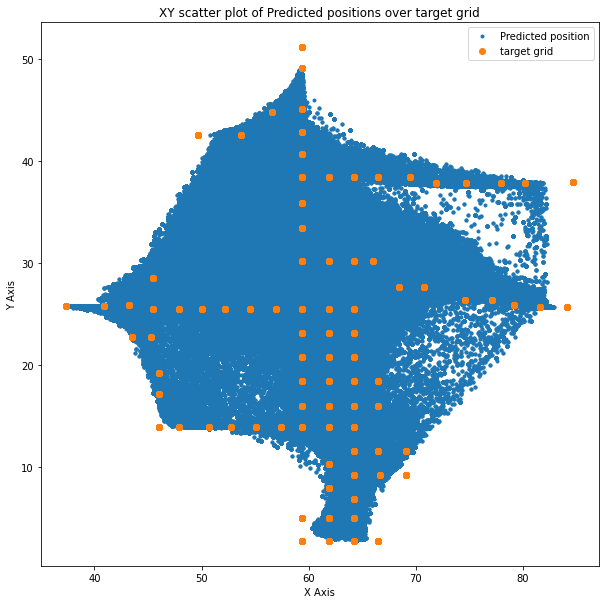

mean validation error, 5-fold 8.122350862974747


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

## Full train

In [ ]:


# name=version+'KNeighbors'



# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values
# knn = neighbors.KNeighborsRegressor(45, weights='distance')
# knn_model=knn.fit(X_train, y_trainXY)
# train_predsXY = knn_model.predict(X_train)

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save Knn model fully trained')
# joblib.dump(knn_model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')